In [1]:
# Bruno Ugolini

# 1. Tennis Surface Check

Use a linear regression and statsmodels to find which surface type predicts the most points for Federer in the `tennis.csv` dataset.

1. Give a one-paragraph interpretation of the coefficients, and the meaning of the p-value. 

2. Answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

3. Do a t-test to find that the largest coefficient is statistically significantly different from the second largest (hint: you can run a t-test only with mean values and standard deviations)

In [128]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
pd.options.mode.chained_assignment = None  # default='warn'

In [129]:
df = pd.read_csv('data/tennis.csv')
surfs = list(df['surface'].value_counts().index)
df['surface'].value_counts()

Outdoor: Hard     482
Outdoor: Clay     249
Indoor: Hard      226
Outdoor: Grass    140
Indoor: Carpet     76
Indoor: Clay        6
Name: surface, dtype: int64

In [130]:
for srfc in surfs:
    cnt = df.loc[df['surface'] == srfc, 'player1 total points won'].count()
    ttl = df.loc[df['surface'] == srfc, 'player1 total points won'].sum()
    print(f"For {srfc}, Federer won a total of {ttl} points in {cnt} matches for an average of {ttl/max(cnt,1):.3f}")

For Outdoor: Hard, Federer won a total of 37532.0 points in 428 matches for an average of 87.692
For Outdoor: Clay, Federer won a total of 19027.0 points in 216 matches for an average of 88.088
For Indoor: Hard, Federer won a total of 14954.0 points in 194 matches for an average of 77.082
For Outdoor: Grass, Federer won a total of 12958.0 points in 132 matches for an average of 98.167
For Indoor: Carpet, Federer won a total of 4744.0 points in 57 matches for an average of 83.228
For Indoor: Clay, Federer won a total of 0.0 points in 0 matches for an average of 0.000


In [5]:
df = df.drop(df.loc[df['surface'] == 'Indoor: Clay'].index,axis=0)

In [6]:
df['surface'].value_counts()

Outdoor: Hard     482
Outdoor: Clay     249
Indoor: Hard      226
Outdoor: Grass    140
Indoor: Carpet     76
Name: surface, dtype: int64

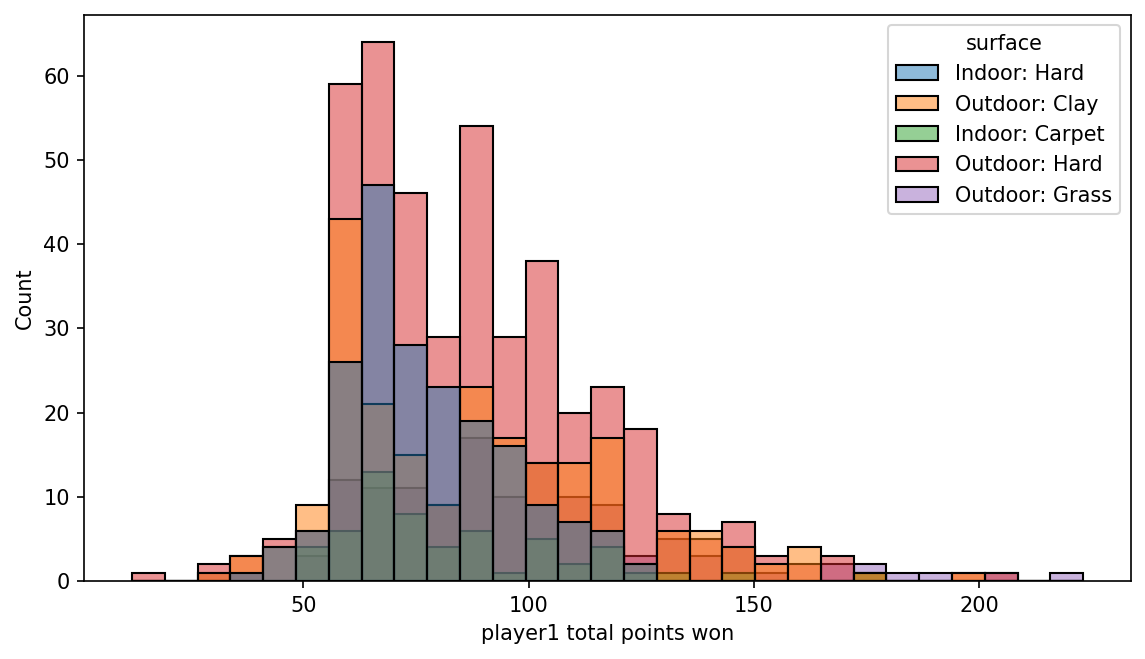

In [8]:
fig = plt.figure(dpi=150, figsize=(9,5))
sns.histplot(data=df,x='player1 total points won',hue='surface');

In [9]:
print(df['surface'].value_counts())
df = pd.get_dummies(data=df, columns=['surface'],drop_first=True)
df = df.dropna(subset=['player1 total points won'],axis=0,how='any')
matching = [s for s in list(df.columns) if "surface" in s]
print(matching)
x = df[matching]
x = sm.add_constant(x)
x

Outdoor: Hard     482
Outdoor: Clay     249
Indoor: Hard      226
Outdoor: Grass    140
Indoor: Carpet     76
Name: surface, dtype: int64
['surface_Indoor: Hard', 'surface_Outdoor: Clay', 'surface_Outdoor: Grass', 'surface_Outdoor: Hard']


,const,surface_Indoor: Hard,surface_Outdoor: Clay,surface_Outdoor: Grass,surface_Outdoor: Hard
0,1.0,1,0,0,0
1,1.0,1,0,0,0
2,1.0,1,0,0,0
3,1.0,1,0,0,0
5,1.0,0,1,0,0
...,...,...,...,...,...
1173,1.0,0,0,0,1
1174,1.0,0,0,0,1
1175,1.0,0,0,0,1
1176,1.0,0,0,0,1


In [13]:
#df.info()
y = df['player1 total points won']
est = sm.OLS(y, x).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.046
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     16.58
Date:                      Sat, 16 Jan 2021   Prob (F-statistic):           3.59e-13
Time:                              09:31:52   Log-Likelihood:                -4849.5
No. Observations:                      1027   AIC:                             9709.
Df Residuals:                          1022   BIC:                             9734.
Df Model:                                 4                                         
Covariance Type:                        HC2                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     83.2281      3.411     24.403      0.000      76.543      89.913
surface_Indoor: Hard      -6.1456      3.629     -1.693      0.090     -13.259       0.968
surface_Outdoor: Clay      4.8599      3.990      1.218      0.223      -2.961      12.680
surface_Outdoor: Grass    14.9386      4.492      3.326      0.001       6.135      23.742
surface_Outdoor: Hard      4.4635      3.657      1.221      0.222      -2.703      11.630
==============================================================================
Omnibus:                      147.179   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.816
Skew:                           0.932   Prob(JB):                     1.88e-53
Kurtosis:                       4.484   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

## The "const" term represents the get_dummies variable that was dropped: Indoor Carpet. It corresponds exactly to the average number of points won by Federer on that surface (see independent calculation several lines above). This constant term is a valid parameter of the regression as determined by the p-value.
## The only other valid p-value is for Outdoor: Grass. For the other three we fail to reject the null hypothesis.
## For each of these surfaces, adding the coefficient value to the "const" term provides the average value of points won for that surface (again, see the calculation above and below).
## The constant term is necessary for the interpretation as described above

In [14]:
results_summary = est.summary()
results_as_html = results_summary.tables[1].as_html()
df_coef = pd.read_html(results_as_html, header=0, index_col=0)[0]
df_coef['coef'][1:]+df_coef['coef'][0]
# repeat of output from above:
# For Indoor: Hard, Federer won a total of 14954.0 points in 194 matches for an average of 77.082
# For Outdoor: Clay, Federer won a total of 19027.0 points in 216 matches for an average of 88.088
# For Outdoor: Grass, Federer won a total of 12958.0 points in 132 matches for an average of 98.167
# For Outdoor: Hard, Federer won a total of 37532.0 points in 428 matches for an average of 87.692

surface_Indoor: Hard      77.0825
surface_Outdoor: Clay     88.0880
surface_Outdoor: Grass    98.1667
surface_Outdoor: Hard     87.6916
Name: coef, dtype: float64

## A t-test is given by the equation:
## t = (beta - 0) / SE
## It measures the number of standard deviations that beta is away from 0. So ...:

In [15]:
df_coef['my t-test calc'] = df_coef['coef'] / df_coef['std err']
df_coef

,coef,std err,z,P>|z|,[0.025,0.975],my t-test calc
const,83.2281,3.411,24.403,0.000,76.543,89.913,24.399912
surface_Indoor: Hard,-6.1456,3.629,-1.693,0.090,-13.259,0.968,-1.693469
surface_Outdoor: Clay,4.8599,3.990,1.218,0.223,-2.961,12.680,1.218020
surface_Outdoor: Grass,14.9386,4.492,3.326,0.001,6.135,23.742,3.325601
surface_Outdoor: Hard,4.4635,3.657,1.221,0.222,-2.703,11.630,1.220536


# 2. Titanic prediction contest

Use whatever tricks you can to best model whether a passenger would survive the titanic disaster (using linear regression).

1. Use non-regularized regression to build the best model you can. Show 2 alternate model speficications and explain why you chose the one you did

2. Interpret the coefficients in your model. Which attributes best relate to survival probability? How does this relate to socio-economic characteristics and "real-world" interpretation?

3. Use regularized regression to build a purely predictive model. Can you improve your accuracy? Plot the regularized model against the interpretable model predictions in a regression plot to make your case.

# 1. Use non-regularized regression to build the best model you can. Show 2 alternate model specifications and explain why you chose the one you did

In [558]:
# read in the data
df = sns.load_dataset('titanic')
# get rid of NaN's
df = df.dropna(subset=['age'],axis=0)
df = df.dropna(subset=['embark_town'],axis=0)
# get rid of "deck" which has too many NaN's
# get rid of "alive" as not relevant to this exercise
# drop "embark_town" as redundant to "embarked"
# drop "class" as redundant to "pclass"
df = df.drop(['deck','alive','embark_town','class'],1)

In [559]:
# look at the data
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,adult_male,alone
0,0,3,male,22.0,1,0,7.2500,S,man,True,False
1,1,1,female,38.0,1,0,71.2833,C,woman,False,False
2,1,3,female,26.0,0,0,7.9250,S,woman,False,True
3,1,1,female,35.0,1,0,53.1000,S,woman,False,False
4,0,3,male,35.0,0,0,8.0500,S,man,True,True
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q,woman,False,False
886,0,2,male,27.0,0,0,13.0000,S,man,True,True
887,1,1,female,19.0,0,0,30.0000,S,woman,False,True
889,1,1,male,26.0,0,0,30.0000,C,man,True,True


## Feature Engineering (kitchen sink on family configurations)

In [560]:
# traveling alone
df['alone'] = df['alone'].map({True: 1, False: 0})

In [561]:
# big family
df['big_fam'] =(df['parch'] >= 3) * 1
# create sex x class interaction terms
df['who_class'] = df['who'] + '_' + df['pclass'].astype(str)
# Create a feature column that combines siblings, parents
df['siblings'] =  df['sibsp'].map(lambda x: 'Sib' if x > 0 else 'NoSib')
df['family'] =  df['parch'].map(lambda x: 'Fam' if x > 0 else 'NoFam')
df['adult'] =  df['who'].map(lambda x: 'Child' if x == 'child' else 'Adult')
df['Fam_config'] = df['siblings'] + '_' + df['family'] + '_' + df['adult']
# convert some of these above to true/false
df['siblings'] =  df['sibsp'].map(lambda x: 1 if x > 0 else 0)
df['adult'] =  df['adult'].map(lambda x: 0 if x == 'Child' else 1)

In [562]:
# create some dummy variables
dummy1 = pd.get_dummies(df['who_class'])
dummy2 = pd.get_dummies(df['Fam_config'],drop_first=True)
dummy3 = pd.get_dummies(df['who'])
df = pd.concat([df,dummy1,dummy2,dummy3],axis=1)

In [563]:
# create log of Fare column
df['log_fare'] = df['fare'].apply(lambda x : np.log(1 + x))
# convert sex to sex_male
df['sex'] = df['sex'].map({'male': 1, 'female':0})


## OLS for the first model

In [564]:
# Here is the kitchen sink ...
# x = (df[['sex', 'age', 'sibsp', 'parch', 'big_fam', 
#         'siblings', 'adult', 'child_2', 'child_3',
#         'man_1', 'man_2', 'man_3', 'woman_1', 'woman_2', 'woman_3',
#         'NoSib_Fam_Child', 'NoSib_NoFam_Adult', 'NoSib_NoFam_Child',
#         'Sib_Fam_Adult', 'Sib_Fam_Child', 'Sib_NoFam_Adult', 'Sib_NoFam_Child',
#         'man', 'woman', 'log_fare']])

x = (df[['age', 'sibsp', 'big_fam', 
        'siblings', 'adult', 'child_2', 'child_3',
        'man_2', 'man_3', 'woman_3',
        'woman', 'log_fare']])

#x = sm.add_constant(x)

y = df['survived']
est = sm.OLS(y,x).fit(cov_type='HC2')
#sm.graphics.plot_fit(est, 'woman', vlines=False,alpha=0.1);
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               survived   R-squared (uncentered):                   0.685
Model:                            OLS   Adj. R-squared (uncentered):              0.679
Method:                 Least Squares   F-statistic:                              816.0
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                        0.00
Time:                        15:47:19   Log-Likelihood:                         -277.08
No. Observations:                 712   AIC:                                      578.2
Df Residuals:                     700   BIC:                                      633.0
Df Model:                          12                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0029      0.001     -2.450      0.014      -0.005      -0.001
sibsp         -0.1649      0.031     -5.323      0.000      -0.226      -0.104
big_fam       -0.2139      0.107     -1.995      0.046      -0.424      -0.004
siblings       0.1326      0.049      2.692      0.007       0.036       0.229
adult          0.2132      0.111      1.925      0.054      -0.004       0.430
child_2        0.7856      0.074     10.611      0.000       0.640       0.931
child_3        0.4628      0.093      5.003      0.000       0.282       0.644
man_2         -0.2643      0.060     -4.379      0.000      -0.383      -0.146
man_3         -0.1670      0.065     -2.565      0.010      -0.295      -0.039
woman_3       -0.4010      0.072     -5.541      0.000      -0.543      -0.259
woman          0.5558      0.054     10.259      0.000       0.450       0.662
log_fare       0.0799      0.023      3.472      0.001       0.035       0.125
==============================================================================
Omnibus:                       65.026   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.725
Skew:                           0.766   Prob(JB):                     1.79e-18
Kurtosis:                       3.641   Cond. No.                         336.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

### NOTE: even though 'adult' is not significant at the 5% level, I decided to keep it anyway because it improves R-squared.
## plot the results of Model 1

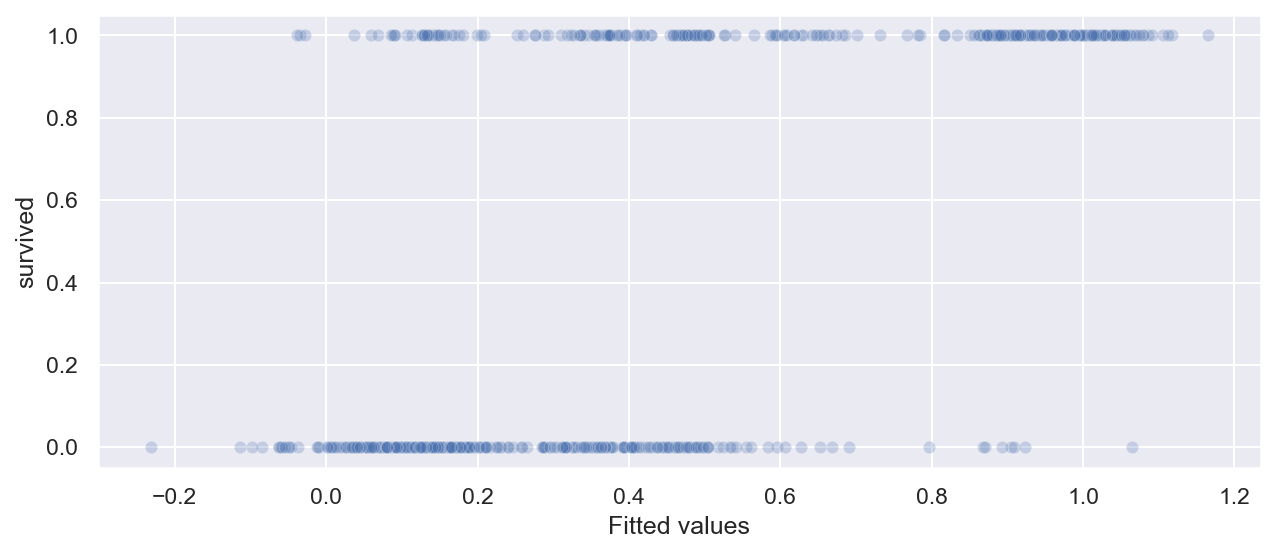

In [565]:
fig = plt.figure(dpi=150,figsize=(10,4))
sns.set()
sns.scatterplot(x=est.fittedvalues,y=y,alpha=0.25);
plt.xlabel('Fitted values');

### Check the results

In [566]:
cut_off = 0.45
y_pred = est.fittedvalues.map(lambda x: 1 if x >= cut_off else 0)
cf = confusion_matrix(y,y_pred)
cf

array([[375,  49],
       [ 77, 211]], dtype=int64)

In [567]:
print(f"Using a cutoff value of {cut_off}:")
print(f"\t Out of {sum(cf[1,:])} actual survivors, {cf[1,0]} were misclassified; {cf[1,1]} were correct.")
print(f"\t Out of {sum(cf[0,:])} actual deaths, {cf[0,1]} were misclassified; {cf[0,0]} were correct.")

Using a cutoff value of 0.45:
	 Out of 288 actual survivors, 77 were misclassified; 211 were correct.
	 Out of 424 actual deaths, 49 were misclassified; 375 were correct.


# Second Model

In [568]:
# read in the data
df = sns.load_dataset('titanic')
# get rid of NaN's
df = df.dropna(subset=['age'],axis=0)
df = df.dropna(subset=['embark_town'],axis=0)
# get rid of "deck" which has too many NaN's
# get rid of "alive" as not relevant to this exercise
# drop "embark_town" as redundant to "embarked"
# drop "class" as redundant to "pclass"
df = df.drop(['deck','alive','embark_town','class'],1)

## Feature Engineering (simpler model this time)

In [569]:
df['child'] = df['who'].map(lambda x : 1 if x == 'child' else 0)
df['alone'] = df['alone'].map({True: 1, False: 0})
df['adult_male'] = df['adult_male'].map({True: 1, False: 0})
df['sex'] = df['sex'].map({'female': 1, 'male': 0})
df['log_fare'] = df['fare'].apply(lambda x : np.log(1 + x))

df.sample(12)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,adult_male,alone,child,log_fare
489,1,3,0,9.0,1,1,15.900,S,child,0,0,1,2.827314
452,0,1,0,30.0,0,0,27.750,C,man,1,1,0,3.358638
634,0,3,1,9.0,3,2,27.900,S,child,0,0,1,3.363842
546,1,2,1,19.0,1,0,26.000,S,woman,0,0,0,3.295837
545,0,1,0,64.0,0,0,26.000,S,man,1,1,0,3.295837
619,0,2,0,26.0,0,0,10.500,S,man,1,1,0,2.442347
705,0,2,0,39.0,0,0,26.000,S,man,1,1,0,3.295837
784,0,3,0,25.0,0,0,7.050,S,man,1,1,0,2.085672
232,0,2,0,59.0,0,0,13.500,S,man,1,1,0,2.674149
729,0,3,1,25.0,1,0,7.925,S,woman,0,0,0,2.188856


## OLS for the first model

In [570]:
#x = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'log_fare', 'adult_male', 'alone', 'child']]
x = df[['sex', 'sibsp', 'parch', 'log_fare', 'adult_male', 'child']]

y = df['survived']
est2 = sm.OLS(y,x).fit(cov_type='HC2')
#sm.graphics.plot_fit(est, 'woman', vlines=False,alpha=0.1);
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               survived   R-squared (uncentered):                   0.641
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              251.9
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                   1.04e-171
Time:                        15:47:35   Log-Likelihood:                         -322.94
No. Observations:                 712   AIC:                                      657.9
Df Residuals:                     706   BIC:                                      685.3
Df Model:                           6                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.2711      0.057      4.728      0.000       0.159       0.383
sibsp         -0.1218      0.020     -6.027      0.000      -0.161      -0.082
parch         -0.0715      0.021     -3.377      0.001      -0.113      -0.030
log_fare       0.1720      0.016     10.957      0.000       0.141       0.203
adult_male    -0.2624      0.042     -6.209      0.000      -0.345      -0.180
child          0.1902      0.059      3.208      0.001       0.074       0.306
==============================================================================
Omnibus:                       23.976   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.533
Skew:                           0.458   Prob(JB):                     2.85e-06
Kurtosis:                       3.150   Cond. No.                         15.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

## plot the results of Model 2

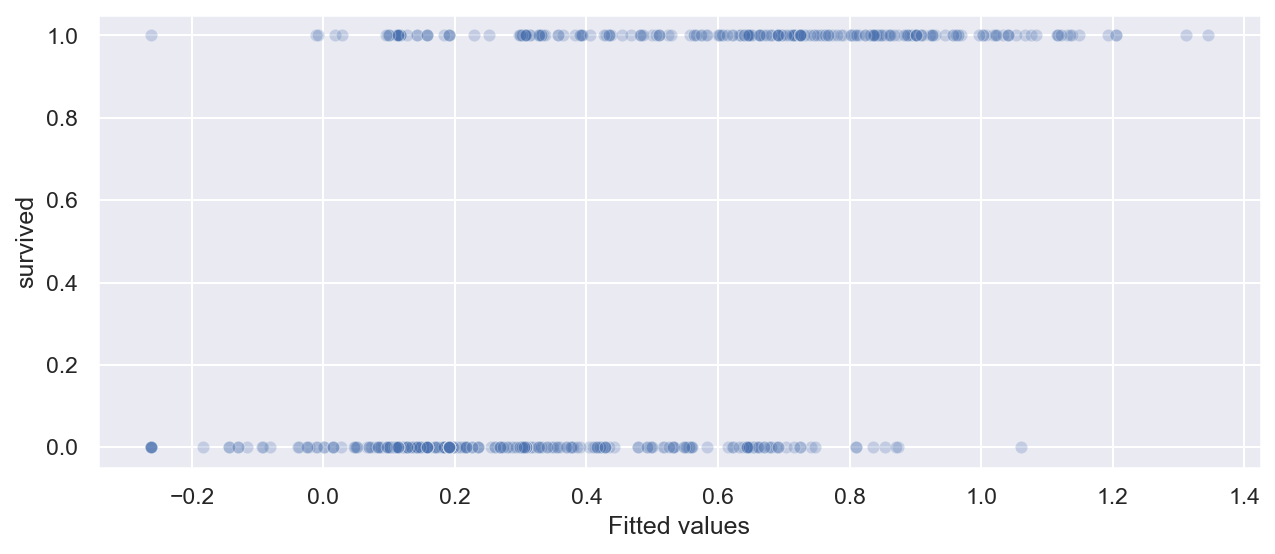

In [571]:
fig = plt.figure(dpi=150,figsize=(10,4))
sns.set()
sns.scatterplot(x=est2.fittedvalues,y=y,alpha=0.25);
plt.xlabel('Fitted values');

### Check the results for Model 2

In [572]:
cut_off2 = 0.45
y_pred = est2.fittedvalues.map(lambda x: 1 if x >= cut_off else 0)
cf2 = confusion_matrix(y,y_pred)
cf2

array([[359,  65],
       [ 77, 211]], dtype=int64)

In [573]:
print(f"Using a cutoff value of {cut_off2}:")
print(f"\t Out of {sum(cf2[1,:])} actual survivors, {cf2[1,0]} were misclassified; {cf2[1,1]} were correct.")
print(f"\t Out of {sum(cf2[0,:])} actual deaths, {cf2[0,1]} were misclassified; {cf2[0,0]} were correct.")

Using a cutoff value of 0.45:
	 Out of 288 actual survivors, 77 were misclassified; 211 were correct.
	 Out of 424 actual deaths, 65 were misclassified; 359 were correct.


# Model Selection: Model 1
## I would choose Model 1 because it has less misclassifications (repeated below for comparison with model 2).

In [574]:
print(f"Using a cutoff value of {cut_off}:")
print(f"\t Out of {sum(cf[1,:])} actual survivors, {cf[1,0]} were misclassified; {cf[1,1]} were correct.")
print(f"\t Out of {sum(cf[0,:])} actual deaths, {cf[0,1]} were misclassified; {cf[0,0]} were correct.")

Using a cutoff value of 0.45:
	 Out of 288 actual survivors, 77 were misclassified; 211 were correct.
	 Out of 424 actual deaths, 49 were misclassified; 375 were correct.


# 2. Interpret the coefficients in your model. Which attributes best relate to survival probability? How does this relate to socio-economic characteristics and "real-world" interpretation?

In [575]:
results_summary = est.summary()
results_as_html = results_summary.tables[1].as_html()
df_coef = pd.read_html(results_as_html, header=0, index_col=0)[0]
df_coef.sort_values(by='coef',ascending=False)

,coef,std err,z,P>|z|,[0.025,0.975]
child_2,0.7856,0.074,10.611,0.000,0.640,0.931
woman,0.5558,0.054,10.259,0.000,0.450,0.662
child_3,0.4628,0.093,5.003,0.000,0.282,0.644
adult,0.2132,0.111,1.925,0.054,-0.004,0.430
siblings,0.1326,0.049,2.692,0.007,0.036,0.229
log_fare,0.0799,0.023,3.472,0.001,0.035,0.125
age,-0.0029,0.001,-2.450,0.014,-0.005,-0.001
sibsp,-0.1649,0.031,-5.323,0.000,-0.226,-0.104
man_3,-0.1670,0.065,-2.565,0.010,-0.295,-0.039
big_fam,-0.2139,0.107,-1.995,0.046,-0.424,-0.004


## The coefficients relate to the probability of survival. That is, the higher the coefficient, the higher the probability of survival. Negative coefficients indicate a decrease in survival probability relative to the others.
## The positive probabilities were for:
- 'child_2': child in 2nd class cabin
- 'woman': as opposed to 'man' or 'child'
- 'child_3': child in 3rd class cabin
- 'adult': as opposed to 'child'
- 'siblings': did have siblings aboard
- 'log_fare': natural log of the ticket fare paid

## The negative probabilities were for:
- 'age': numerical age
- 'sibsp': the number of siblings aboard
- 'man_3': man in 3rd class cabin
- 'big_fam': an adult with 3 or more children or siblings aboard
- 'man_2': man in 2nd class cabin
- 'woman_3': woman in 3rd class cabin

## Interpretation of results
### The first three positive coefficients listed above relate to the priority of saving "women and children first". We note that there were only 6 children in 1st class of which 5 survived. The model did not capture these into the regression well however.
### We note that adults in 2nd or 3rd class had negative probability coefficients.
### In general, the model indicates the social order of saving women and children first and a bias against 2nd and 3rd class occupants.

# 3. Use regularized regression to build a purely predictive model. Can you improve your accuracy? Plot the regularized model against the interpretable model predictions in a regression plot to make your case.

## Regularized Model for Model 2

In [576]:
# read in the data
df = sns.load_dataset('titanic')
# get rid of NaN's
df = df.dropna(subset=['age'],axis=0)
df = df.dropna(subset=['embark_town'],axis=0)
# get rid of "deck" which has too many NaN's
# get rid of "alive" as not relevant to this exercise
# drop "embark_town" as redundant to "embarked"
# drop "class" as redundant to "pclass"
df = df.drop(['deck','alive','embark_town','class'],1)
df['child'] = df['who'].map(lambda x : 1 if x == 'child' else 0)
df['alone'] = df['alone'].map({True: 1, False: 0})
df['adult_male'] = df['adult_male'].map({True: 1, False: 0})
df['sex'] = df['sex'].map({'female': 1, 'male': 0})
df['log_fare'] = df['fare'].apply(lambda x : np.log(1 + x))

In [577]:
#x = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'log_fare', 'adult_male', 'alone', 'child']]
x = df[['sex', 'age', 'sibsp', 'parch', 'log_fare', 'adult_male', 'child']]
y = df['survived']
#est = sm.OLS(y,x).fit_regularized(method='elastic_net', alpha=0.8, L1_wt=0.0)

In [578]:
alphas = np.linspace(0,1,21)
L1s = np.linspace(0,1,21)
cut_off = 0.45
res_dict = {}
for alpha in alphas:
    for L1 in L1s:
        est3 = (sm.OLS(y,x)
               .fit_regularized(method='elastic_net', 
                                alpha=alpha, 
                                L1_wt=L1))
        y_pred3 = (pd.Series(est3.fittedvalues)
                  .map(lambda x: 1 if x >= cut_off else 0))
        cf3 = confusion_matrix(y,y_pred3)
        res_dict[str(f"{alpha:0.2f}") + '_' + str(f"{L1:0.2f}")] = [cf3[0,1], cf3[1,0]]

In [579]:
score_to_beat = 49 + 77 # previous misclassifications
for vals in res_dict.values():
    total_misclass = sum(vals)
    if total_misclass <= score_to_beat:
        print(f"Sum is {total_misclass} compared to {score_to_beat}.")

## Conclusion for Model 2: There is no improvement via regularization

## Regularized Model for Model 1

In [580]:
# read in the data
df = sns.load_dataset('titanic')
# get rid of NaN's
df = df.dropna(subset=['age'],axis=0)
df = df.dropna(subset=['embark_town'],axis=0)
# get rid of "deck" which has too many NaN's
# get rid of "alive" as not relevant to this exercise
# drop "embark_town" as redundant to "embarked"
# drop "class" as redundant to "pclass"
df = df.drop(['deck','alive','embark_town','class'],1)

# traveling alone
df['alone'] = df['alone'].map({True: 1, False: 0})

# big family
df['big_fam'] =(df['parch'] >= 3) * 1
# create sex x class interaction terms
df['who_class'] = df['who'] + '_' + df['pclass'].astype(str)
# Create a feature column that combines siblings, parents
df['siblings'] =  df['sibsp'].map(lambda x: 'Sib' if x > 0 else 'NoSib')
df['family'] =  df['parch'].map(lambda x: 'Fam' if x > 0 else 'NoFam')
df['adult'] =  df['who'].map(lambda x: 'Child' if x == 'child' else 'Adult')
df['Fam_config'] = df['siblings'] + '_' + df['family'] + '_' + df['adult']
# convert some of these above to true/false
df['siblings'] =  df['sibsp'].map(lambda x: 1 if x > 0 else 0)
df['adult'] =  df['adult'].map(lambda x: 0 if x == 'Child' else 1)

# create some dummy variables
dummy1 = pd.get_dummies(df['who_class'])
dummy2 = pd.get_dummies(df['Fam_config'],drop_first=True)
dummy3 = pd.get_dummies(df['who'])
df = pd.concat([df,dummy1,dummy2,dummy3],axis=1)

# create log of Fare column
df['log_fare'] = df['fare'].apply(lambda x : np.log(1 + x))
# convert sex to sex_male
df['sex'] = df['sex'].map({'male': 1, 'female':0})


In [581]:
# Here is the kitchen sink ...
x = (df[['sex', 'age', 'sibsp', 'parch', 'big_fam', 
        'siblings', 'adult', 'child_2', 'child_3',
        'man_1', 'man_2', 'man_3', 'woman_1', 'woman_2', 'woman_3',
        'NoSib_Fam_Child', 'NoSib_NoFam_Adult', 'NoSib_NoFam_Child',
        'Sib_Fam_Adult', 'Sib_Fam_Child', 'Sib_NoFam_Adult', 'Sib_NoFam_Child',
        'man', 'woman', 'log_fare']])

y = df['survived']

In [582]:
alphas = np.linspace(0,1,21)
L1s = np.linspace(0,1,21)
cut_off = 0.5
res_dict = {}
for alpha in alphas:
    for L1 in L1s:
        est4 = (sm.OLS(y,x)
               .fit_regularized(method='elastic_net', 
                                alpha=alpha, 
                                L1_wt=L1))
        y_pred4 = (pd.Series(est4.fittedvalues)
                  .map(lambda x: 1 if x >= cut_off else 0))
        cf4 = confusion_matrix(y,y_pred4)
        res_dict[str(f"{alpha:0.2f}") + '_' + str(f"{L1:0.2f}")] = [cf4[0,1], cf4[1,0]]

In [583]:
score_to_beat = 49 + 77
for key, vals in res_dict.items():
    total_misclass = sum(vals)
    if total_misclass <= score_to_beat:
        print(f"Sum is {total_misclass} compared to {score_to_beat}.")
        print(f"\tfor alpha and L1 values of {key}")

Sum is 125 compared to 126.
	for alpha and L1 values of 0.00_0.00


In [557]:
res_dict['0.00_0.00']

[18, 107]

## Conclusion for Model 1: There is a lower score of overall misclassifications when using all the features (kitchen sink approach). Ironically, it is the non-regularized response (alpha = 0, L1 = 0) but with more features than I selected above.
## However, the misclassifications are more imbalanced. Whereas the model selected above gave 49 & 77 misclassifications, this one gives 18 & 107. I guess this new model could be used depending on the aim of the work.

In [591]:
est4 = (sm.OLS(y,x)
        .fit_regularized(method='elastic_net', 
                         alpha=0, L1_wt=0))
y_pred4 = (pd.Series(est4.fittedvalues)
           .map(lambda x: 1 if x >= cut_off else 0))
cf4 = confusion_matrix(y,y_pred4)

## Regularized model confusion matrix compared with unregularized model:

In [593]:
print(cf4)
print(f"Using a cutoff value of {cut_off}:")
print(f"\t Out of {sum(cf4[1,:])} actual survivors, {cf4[1,0]} were misclassified; {cf4[1,1]} were correct.")
print(f"\t Out of {sum(cf4[0,:])} actual deaths, {cf4[0,1]} were misclassified; {cf4[0,0]} were correct.")

[[406  18]
 [107 181]]
Using a cutoff value of 0.5:
	 Out of 288 actual survivors, 107 were misclassified; 181 were correct.
	 Out of 424 actual deaths, 18 were misclassified; 406 were correct.


In [596]:
print(cf)
print(f"Using a cutoff value of {cut_off}:")
print(f"\t Out of {sum(cf[1,:])} actual survivors, {cf[1,0]} were misclassified; {cf[1,1]} were correct.")
print(f"\t Out of {sum(cf[0,:])} actual deaths, {cf[0,1]} were misclassified; {cf[0,0]} were correct.")

[[375  49]
 [ 77 211]]
Using a cutoff value of 0.5:
	 Out of 288 actual survivors, 77 were misclassified; 211 were correct.
	 Out of 424 actual deaths, 49 were misclassified; 375 were correct.


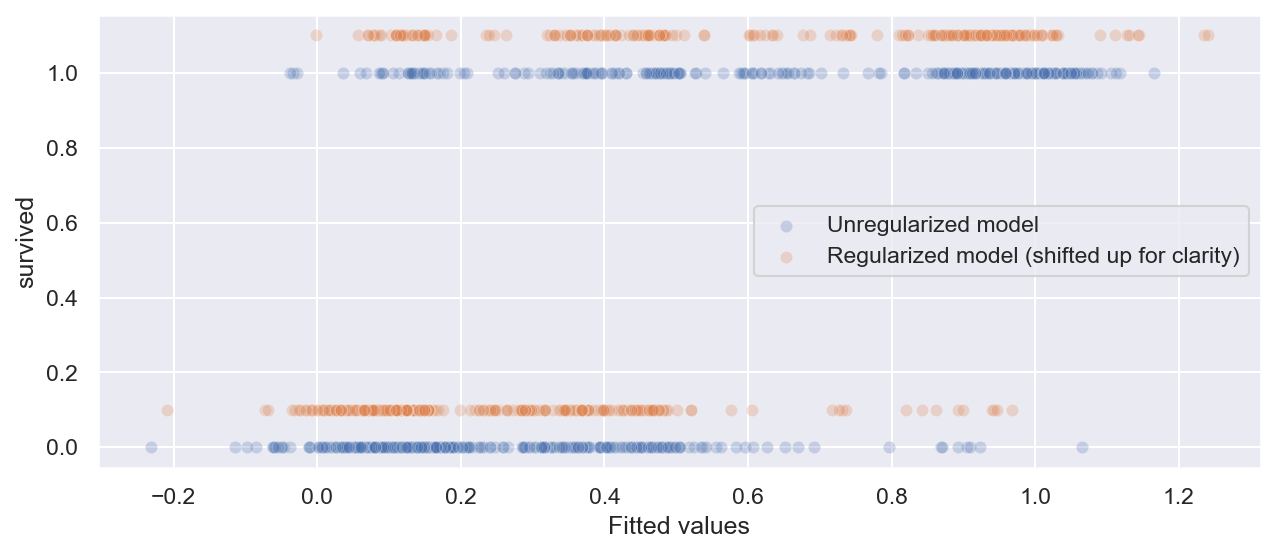

In [597]:
fig = plt.figure(dpi=150,figsize=(10,4))
sns.set()
sns.scatterplot(x=est.fittedvalues,y=y,alpha=0.25,label='Unregularized model');
sns.scatterplot(x=est4.fittedvalues,y=y+0.1,alpha=0.25,label='Regularized model (shifted up for clarity)');
plt.xlabel('Fitted values');

## This regularized model is better at classifying actual deaths with only 18 actual deaths misclassified.

# House Price prediction

Using the techniques you learned, use everything you can to build the best **interpretable** (eg. non-regularized) regression model on the `house_price.csv` dataset. You also have `house_price_data_description.txt` to help -- full description of each column.

Here's a brief version of what you'll find in the data description file.

**SalePrice** - the property's sale price in dollars. **This is the target variable that you're trying to predict.**

Here are the features you can use (or engineer into new features!) for your `X` matrix:

    MSSubClass: The building class
    MSZoning: The general zoning classification
    LotFrontage: Linear feet of street connected to property
    LotArea: Lot size in square feet
    Street: Type of road access
    Alley: Type of alley access
    LotShape: General shape of property
    LandContour: Flatness of the property
    Utilities: Type of utilities available
    LotConfig: Lot configuration
    LandSlope: Slope of property
    Neighborhood: Physical locations within Ames city limits
    Condition1: Proximity to main road or railroad
    Condition2: Proximity to main road or railroad (if a second is present)
    BldgType: Type of dwelling
    HouseStyle: Style of dwelling
    OverallQual: Overall material and finish quality
    OverallCond: Overall condition rating
    YearBuilt: Original construction date
    YearRemodAdd: Remodel date
    RoofStyle: Type of roof
    RoofMatl: Roof material
    Exterior1st: Exterior covering on house
    Exterior2nd: Exterior covering on house (if more than one material)
    MasVnrType: Masonry veneer type
    MasVnrArea: Masonry veneer area in square feet
    ExterQual: Exterior material quality
    ExterCond: Present condition of the material on the exterior
    Foundation: Type of foundation
    BsmtQual: Height of the basement
    BsmtCond: General condition of the basement
    BsmtExposure: Walkout or garden level basement walls
    BsmtFinType1: Quality of basement finished area
    BsmtFinSF1: Type 1 finished square feet
    BsmtFinType2: Quality of second finished area (if present)
    BsmtFinSF2: Type 2 finished square feet
    BsmtUnfSF: Unfinished square feet of basement area
    TotalBsmtSF: Total square feet of basement area
    Heating: Type of heating
    HeatingQC: Heating quality and condition
    CentralAir: Central air conditioning
    Electrical: Electrical system
    1stFlrSF: First Floor square feet
    2ndFlrSF: Second floor square feet
    LowQualFinSF: Low quality finished square feet (all floors)
    GrLivArea: Above grade (ground) living area square feet
    BsmtFullBath: Basement full bathrooms
    BsmtHalfBath: Basement half bathrooms
    FullBath: Full bathrooms above grade
    HalfBath: Half baths above grade
    Bedroom: Number of bedrooms above basement level
    Kitchen: Number of kitchens
    KitchenQual: Kitchen quality
    TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    Functional: Home functionality rating
    Fireplaces: Number of fireplaces
    FireplaceQu: Fireplace quality
    GarageType: Garage location
    GarageYrBlt: Year garage was built
    GarageFinish: Interior finish of the garage
    GarageCars: Size of garage in car capacity
    GarageArea: Size of garage in square feet
    GarageQual: Garage quality
    GarageCond: Garage condition
    PavedDrive: Paved driveway
    WoodDeckSF: Wood deck area in square feet
    OpenPorchSF: Open porch area in square feet
    EnclosedPorch: Enclosed porch area in square feet
    3SsnPorch: Three season porch area in square feet
    ScreenPorch: Screen porch area in square feet
    PoolArea: Pool area in square feet
    PoolQC: Pool quality
    Fence: Fence quality
    MiscFeature: Miscellaneous feature not covered in other categories
    MiscVal: $Value of miscellaneous feature
    MoSold: Month Sold
    YrSold: Year Sold
    SaleType: Type of sale
    SaleCondition: Condition of sale


In [123]:
df = pd.read_csv('data/house_price.csv')

# Feature Engineering

In [124]:
# Convert MSZoning to an ordinal scale
map_dic = {'A': 0,
           'I': 1,
           'C': 2,
           'RP': 3,
           'RM': 4,
           'RH': 5,
           'FV': 6,
           'RL': 7}
df['MSZoning'] = df['MSZoning'].map(map_dic)
df['ExterQual'] = df['ExterQual'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
df['BsmtQual'] = df['BsmtQual'].map({np.NaN:0 , 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df['BsmtExposure'] = df['BsmtExposure'].map({np.NaN: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4})
df['HeatingQC'] = df['HeatingQC'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
df['KitchenQual'] = df['KitchenQual'].map({np.NaN:0 , 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df['GarageQual'] = df['GarageQual'].map({np.NaN:0 , 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

# Fill in some missing values with the median
df['LotFrontage'] = df['LotFrontage'].fillna(value=df.describe()['LotFrontage']['50%'])

# convert some features to a log function
df['Log_BsmtFinSF1'] = df['BsmtFinSF1'].apply(lambda x : np.log(1 + x))
df['Log_LowQualFinSF'] = df['LowQualFinSF'].apply(lambda x : np.log(1 + x))

# create dummy variables
dummy1 = pd.get_dummies(df['Neighborhood'],prefix='NB',drop_first=True)
dummy2 = pd.get_dummies(df['Condition1'],prefix='C1',drop_first=True)
dummy3 = pd.get_dummies(df['BldgType'],prefix='BT',drop_first=True)
dummy5 = pd.get_dummies(df['RoofStyle'],prefix='RS',drop_first=True)
dummy12 = pd.get_dummies(df['SaleType'],prefix='ST')
# this creates ST_COD ST_CWD ST_Con ST_ConLD ST_ConLI ST_ConLw ST_New ST_Oth ST_WD
# but we remove ST_WD since it is a conventional sale type
dummy12 = dummy12.drop(['ST_WD'],1)
dummy13 = pd.get_dummies(df['SaleCondition'],prefix='SC',drop_first=True)

df = pd.concat([df,
                dummy1,dummy2,dummy3,dummy4,
                dummy5,dummy6,dummy7,dummy8,
                dummy9, dummy10, dummy11, dummy12, dummy13],axis=1)
# drop NaN values
df = df.dropna(subset=['MSZoning'],axis=0)

In [125]:
x = df[['MSSubClass', 'LotFrontage',
       'OverallQual', 'BsmtExposure',
       'BsmtQual',  
       'Log_BsmtFinSF1', 
       'HeatingQC', 
       'Log_LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'KitchenQual', 'Fireplaces',
       'GarageCars', 
       'GarageQual', 'WoodDeckSF', 
       '3SsnPorch', 'ScreenPorch',
       ]]  

# Polynomials
poly_cols = ['OverallQual', 'BsmtExposure', 
             'LotFrontage', 
             'KitchenQual', 'GarageCars']
for poly in poly_cols:
    x[poly + '_2'] = np.square(x[poly])
    x[poly + '_3'] = np.square(x[poly]) * x[poly]


matching = [s for s in df.columns if "NB_" in s]
x = pd.concat([x, df[matching]],axis=1) # together with top or R-sq=0.87 gives R-sq=0.957
matching = [s for s in df.columns if "ST_" in s]
x = pd.concat([x, df[matching]],axis=1) # together with top or R-sq=0.87 gives R-sq=0.957
matching = [s for s in df.columns if "C1_" in s]
x = pd.concat([x, df[matching]],axis=1) # together with top or R-sq=0.87 gives R-sq=0.957
matching = [s for s in df.columns if "BT_" in s]
x = pd.concat([x, df[matching]],axis=1) # together with top or R-sq=0.87 gives R-sq=0.959
matching = [s for s in df.columns if "RS_" in s]
x = pd.concat([x, df[matching]],axis=1) # together with top or R-sq=0.87 gives R-sq=0.961
matching = [s for s in df.columns if "SC_" in s]
x = pd.concat([x, df[matching]],axis=1) # together with top or R-sq=0.87 gives R-sq=0.961

# remove features that result in insignificant p-values
x = x.drop(['NB_Timber', 
            'NB_BrkSide', 'RS_Gable',
            'RS_Mansard', 'ST_CWD', 'ST_Oth', 
            'ST_ConLD', 'BT_Duplex', 'ST_ConLI', 'ST_ConLw',
            'RS_Shed', 'OverallQual', 
            'NB_CollgCr', 'NB_SawyerW', 
            'NB_Mitchel', 'NB_Sawyer', 'NB_SWISU', 
            'NB_NAmes', 'NB_IDOTRR',
            'NB_Gilbert', 'NB_NWAmes', 
            'ST_Con', 'C1_PosA', 'C1_RRNn', 'C1_RRAn',
            'C1_PosN', 'C1_RRNe', 'C1_Feedr', 'RS_Gambrel', 
            'C1_RRAe', 'KitchenQual', 'SC_Alloca',
            'BT_TwnhsE', 'SC_Family', 'SC_Partial',
            'NB_Blueste', 'BT_Twnhs', 'NB_MeadowV', 'NB_ClearCr',
            'ST_COD', 'LotFrontage_3', 'BsmtExposure_3',
            'KitchenQual_2'],1)

y = df['SalePrice']

est = sm.OLS(y, x).fit(cov_type='HC2')

est.summary()
#
# Values ignored and why:
#     Street: only 6 gravel streets
#     Alley: only 91 wiht alley access and only for the lower end of price range
#     Utilities: only one non-uniform
#     Condition2: only a few non-uniform
#     OverallCond: doesn't appear to add value over OverallQual
#     YearBuilt: doesn't appear to add value
#     YearRemodAdd: doesn't appear to add value
#         Note: previous two elements were added in the form of a delta year
#     RoofMatl: only a few non-uniform
#     MasVnrType: ? may or may not include
#     ExterCond: doesn't add value over ExterQual
#     Heating: very few non-uniform
#     GarageYrBlt: would require dropping or fudging 79 Nan's but this variable is highly correlated to YearBuilt anyway
#     PoolArea, PoolQC: too few datapoints

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                              3222.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):                        0.00
Time:                        22:59:30   Log-Likelihood:                         -16883.
No. Observations:                1450   AIC:                                  3.384e+04
Df Residuals:                    1412   BIC:                                  3.404e+04
Df Model:                          38                                                  
Covariance Type:                  HC2                                                  
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
MSSubClass        -221.4129     26.575     -8.332      0.000    -273.498    -169.328
LotFrontage        491.9376    387.242      1.270      0.204    -267.043    1250.918
BsmtExposure      -1.55e+04   5180.854     -2.992      0.003   -2.57e+04   -5345.867
BsmtQual          6991.4228   1209.160      5.782      0.000    4621.513    9361.333
Log_BsmtFinSF1    1663.5737    337.190      4.934      0.000    1002.694    2324.454
HeatingQC         3371.1429    757.836      4.448      0.000    1885.811    4856.475
Log_LowQualFinSF -2946.3879   1121.186     -2.628      0.009   -5143.873    -748.903
GrLivArea           51.2278      5.752      8.906      0.000      39.955      62.501
BsmtFullBath      5572.8744   2043.194      2.728      0.006    1568.289    9577.460
Fireplaces        5052.4828   1591.853      3.174      0.002    1932.508    8172.458
GarageCars       -4.871e+04    1.8e+04     -2.699      0.007   -8.41e+04   -1.33e+04
GarageQual        1.008e+04   3043.253      3.313      0.001    4118.682     1.6e+04
WoodDeckSF          18.7096      7.234      2.586      0.010       4.531      32.888
3SsnPorch           57.0023     25.303      2.253      0.024       7.409     106.596
ScreenPorch         47.6558     16.139      2.953      0.003      16.025      79.287
OverallQual_2    -1512.0688    941.799     -1.606      0.108   -3357.962     333.824
OverallQual_3      255.6976     99.479      2.570      0.010      60.722     450.673
BsmtExposure_2    4931.6822   1225.104      4.026      0.000    2530.522    7332.842
LotFrontage_2       -3.0363      2.675     -1.135      0.256      -8.279       2.207
KitchenQual_3      278.9464     42.573      6.552      0.000     195.505     362.388
GarageCars_2      2.774e+04   9752.453      2.845      0.004    8630.520    4.69e+04
GarageCars_3     -3832.2636   1498.492     -2.557      0.011   -6769.253    -895.274
NB_BrDale         1.719e+04   5570.730      3.086      0.002    6272.529    2.81e+04
NB_Crawfor        2.387e+04   5120.806      4.661      0.000    1.38e+04    3.39e+04
NB_Edwards       -1.524e+04   4713.787     -3.233      0.001   -2.45e+04   -6002.969
NB_NPkVill        1.836e+04   4939.139      3.717      0.000    8676.817     2.8e+04
NB_NoRidge        4.352e+04   1.01e+04      4.330      0.000    2.38e+04    6.32e+04
NB_NridgHt        3.081e+04   7858.782      3.921      0.000    1.54e+04    4.62e+04
NB_OldTown       -1.145e+04   2300.930     -4.974      0.000    -1.6e+04   -6935.884
NB_Somerst        1.751e+04   3904.564      4.485      0.000    9859.326    2.52e+04
NB_StoneBr        4.496e+04    1.2e+04      3.756      0.000    2.15e+04    6.84e+04
NB_Veenker        2.299e+04   7622.786      3.016      0.003    8050.731    3.79e+04
ST_New   

# Check the highest p-values for possible deletion

In [126]:
results_summary = est.summary()
results_as_html = results_summary.tables[1].as_html()
df_coef = pd.read_html(results_as_html, header=0, index_col=0)[0]
df_coef.sort_values('P>|z|',ascending=False).head(5)

,coef,std err,z,P>|z|,[0.025,0.975]
LotFrontage_2,-3.0363,2.675,-1.135,0.256,-8.279,2.207
LotFrontage,491.9376,387.242,1.270,0.204,-267.043,1250.918
RS_Hip,3221.5035,2127.066,1.515,0.130,-947.470,7390.477
OverallQual_2,-1512.0688,941.799,-1.606,0.108,-3357.962,333.824
3SsnPorch,57.0023,25.303,2.253,0.024,7.409,106.596


# Check for lower AIC

In [127]:
for c in x.columns:
    new_x = x.drop(columns=c)
    new_est = sm.OLS(y, new_x).fit(cov_type='HC2')
    print(f"{c} : {new_est.aic - est.aic}")

MSSubClass : 80.35045011149487
LotFrontage : 37.12502163672616
BsmtExposure : 11.707335387909552
BsmtQual : 25.9545461514208
Log_BsmtFinSF1 : 24.15653492232377
HeatingQC : 11.77784909667389
Log_LowQualFinSF : 6.210410127736395
GrLivArea : 488.4155730799248
BsmtFullBath : 7.1154066497038
Fireplaces : 11.429040531889768
GarageCars : 7.92926001867454
GarageQual : 10.035024318858632
WoodDeckSF : 6.593858575230115
3SsnPorch : 3.1997468386398396
ScreenPorch : 10.486447283161397
OverallQual_2 : 17.38927386442083
OverallQual_3 : 55.152905968701816
BsmtExposure_2 : 27.382483947338187
LotFrontage_2 : 70.86399249675014
KitchenQual_3 : 47.33214918215526
GarageCars_2 : 9.295132267594454
GarageCars_3 : 6.038183073658729
NB_BrDale : 3.077566186642798
NB_Crawfor : 30.84401468485885
NB_Edwards : 22.651968826052325
NB_NPkVill : 1.5991411559807602
NB_NoRidge : 74.38610483922093
NB_NridgHt : 53.61128220410319
NB_OldTown : 12.859218503952434
NB_Somerst : 22.183391801394464
NB_StoneBr : 52.814225977090246
N

# Plot results

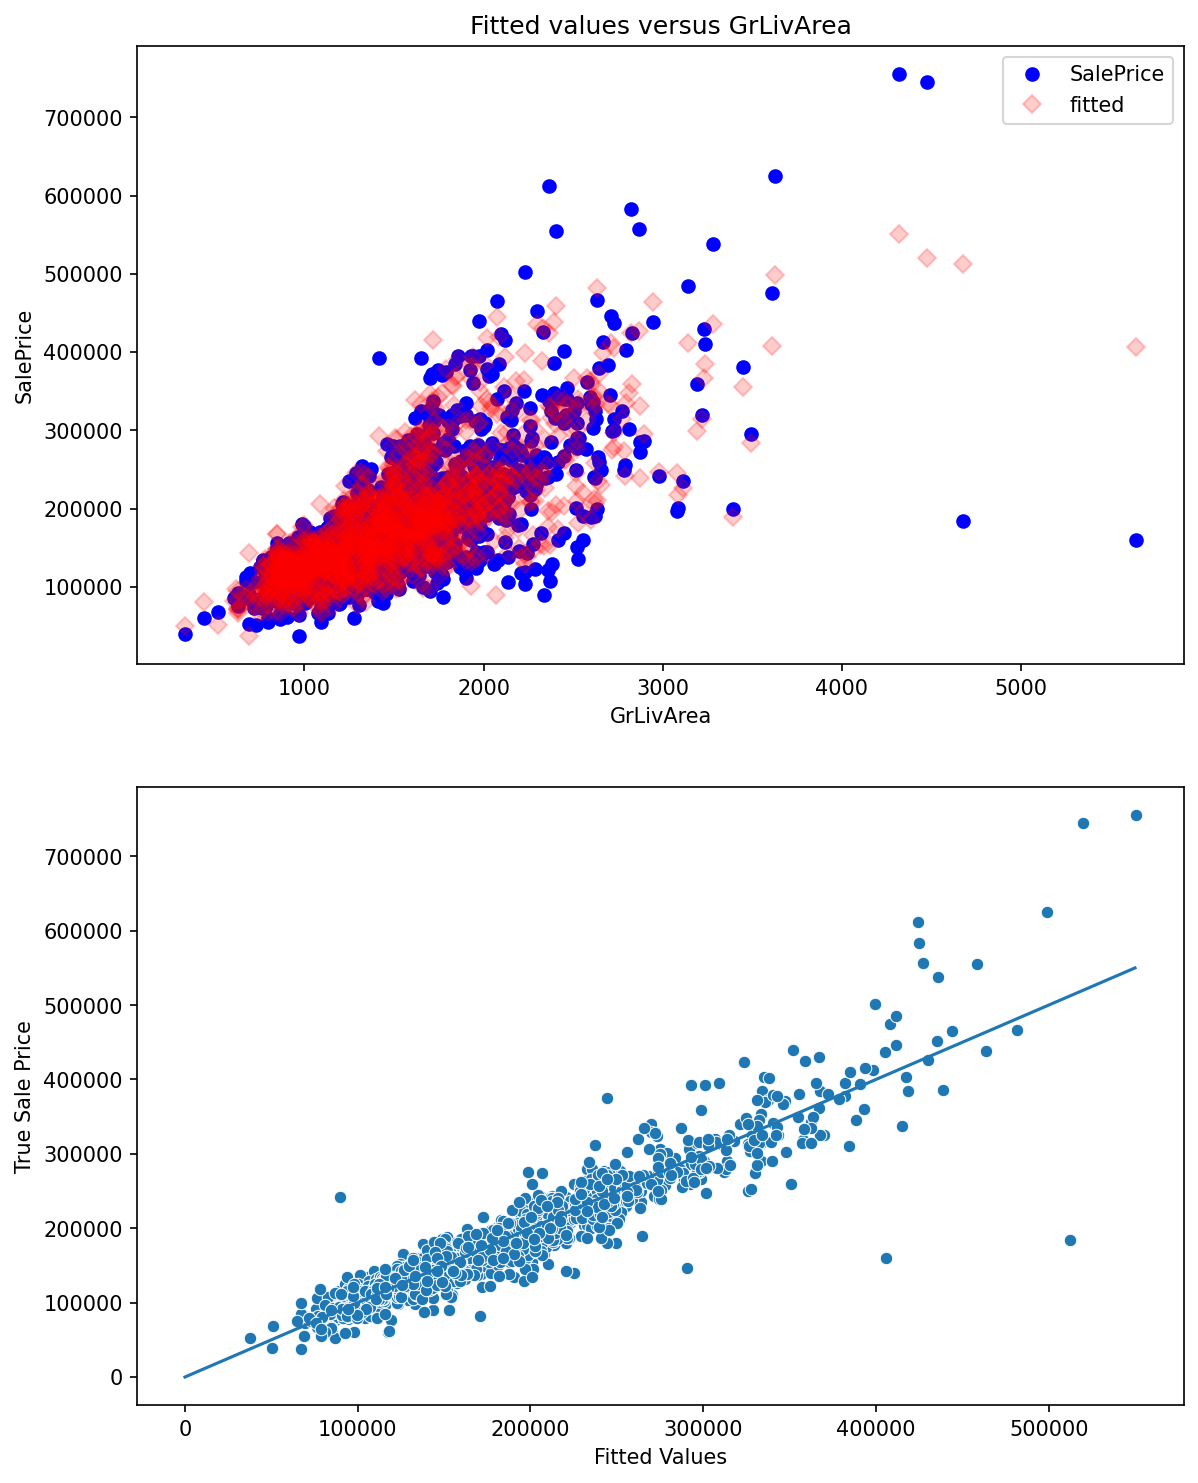

In [122]:
fig, (ax1, ax2) = plt.subplots(2,1, dpi=150, figsize=(9,12))
sm.graphics.plot_fit(est, 'GrLivArea', vlines=False,alpha=0.2,ax=ax1);
sns.scatterplot(x=est.fittedvalues, y=y, ax=ax2)
sns.lineplot(x=[0,550000], y=[0,550000], ax=ax2)
ax2.set_xlabel('Fitted Values')
ax2.set_ylabel('True Sale Price');